In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os
import cv2
from PIL import Image
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import time
import datetime

In [2]:
# date_time function

def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [3]:
# Performance Plot

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [4]:
# Setting variables for later use
data = []
labels = []
classes = 43
cur_path = os.getcwd()

# Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join('dataset/','train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

#print data

In [8]:
def preprocessing(img, use_clahe=False, augment=False, use_filters=False, show_intermediate=False):
    """
    Preprocess the image with options for CLAHE, augmentation, and filters.
    
    Parameters:
        img (numpy.ndarray): The input image in BGR format.
        use_clahe (bool): Whether to apply CLAHE.
        augment (bool): Whether to apply random augmentations.
        use_filters (bool): Whether to apply filtering techniques.
        show_intermediate (bool): Whether to display intermediate results.
    
    Returns:
        numpy.ndarray: The preprocessed image.
    """
    def show_image(title, image):
        plt.figure()
        plt.title(title)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()

    target_size = (32, 32)

    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show_intermediate:
        show_image('Grayscale', img_gray)

    # Apply CLAHE if specified
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_gray = clahe.apply(img_gray)
        if show_intermediate:
            show_image('After CLAHE', img_gray)

    # Apply filters if specified
    if use_filters:
        # Gaussian Blur
        img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
        if show_intermediate:
            show_image('After Gaussian Blur', img_blur)

        # Sobel Edge Detection
        sobelx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(img_blur, cv2.CV_64F, 0, 1, ksize=5)
        img_sobel = cv2.magnitude(sobelx, sobely)
        if show_intermediate:
            show_image('After Sobel Edge Detection', img_sobel)

        # Sharpening
        kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]])
        img_sharpen = cv2.filter2D(img_sobel, -1, kernel)
        if show_intermediate:
            show_image('After Sharpening', img_sharpen)

        # Assign the final processed image after filtering
        img_gray = img_sharpen

    # Normalize the image to the range [0, 1]
    img_normalized = img_gray / 255.0
    if show_intermediate:
        show_image('Final Output After Normalization', img_normalized)

    # Expand dimensions to include channel (for grayscale images)
    img_normalized = np.expand_dims(img_normalized, axis=-1)

    # Apply augmentation if specified
    if augment:
        if np.random.rand() > 0.5:
            # Rotate the image
            angle = np.random.randint(-15, 15)
            M = cv2.getRotationMatrix2D((img_normalized.shape[1] // 2, img_normalized.shape[0] // 2), angle, 1.0)
            img_normalized = cv2.warpAffine(img_normalized, M, (img_normalized.shape[1], img_normalized.shape[0]))

        if np.random.rand() > 0.5:
            # Scale the image
            scale = np.random.uniform(0.9, 1.1)
            height, width = img_normalized.shape[:2]
            new_height, new_width = int(height * scale), int(width * scale)
            img_scaled = cv2.resize(img_normalized, (new_width, new_height))
            img_normalized = cv2.resize(img_scaled, target_size)  # Resize back to original size

    # Ensure consistent image size
    img_normalized = cv2.resize(img_normalized, target_size)

    return img_normalized

# Preprocess the entire dataset and expand dimensions
preprocessed_data = np.array([preprocessing(img, use_clahe=True, augment=True, use_filters=True) for img in data])


# Checking data shape
print(preprocessed_data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(39209, 32, 32) (39209,)
(31367, 32, 32) (7842, 32, 32) (31367,) (7842,)


In [10]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(32, 32, 1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#M odel display
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          36928     
                                                      

In [11]:
# Training the Model
with tf.device('/GPU:0'):
    epochs = 25
    history1 = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/25


2024-05-08 20:53:26.907352: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-08 20:53:27.367310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


491/491 [==============================] - ETA: 0s - loss: 1.5396 - accuracy: 0.5728

2024-05-08 20:53:38.921541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


491/491 [==============================] - 13s 24ms/step - loss: 1.5396 - accuracy: 0.5728 - val_loss: 0.3966 - val_accuracy: 0.8812
Epoch 2/25
491/491 [==============================] - 11s 23ms/step - loss: 0.5070 - accuracy: 0.8459 - val_loss: 0.2212 - val_accuracy: 0.9368
Epoch 3/25
491/491 [==============================] - 11s 23ms/step - loss: 0.3555 - accuracy: 0.8887 - val_loss: 0.1811 - val_accuracy: 0.9448
Epoch 4/25
491/491 [==============================] - 11s 23ms/step - loss: 0.2818 - accuracy: 0.9131 - val_loss: 0.1332 - val_accuracy: 0.9606
Epoch 5/25
491/491 [==============================] - 11s 22ms/step - loss: 0.2450 - accuracy: 0.9230 - val_loss: 0.1311 - val_accuracy: 0.9591
Epoch 6/25
491/491 [==============================] - 11s 22ms/step - loss: 0.2168 - accuracy: 0.9318 - val_loss: 0.1336 - val_accuracy: 0.9606
Epoch 7/25
491/491 [==============================] - 11s 22ms/step - loss: 0.1980 - accuracy: 0.9379 - val_loss: 0.1114 - val_accuracy: 0.9642
Epo

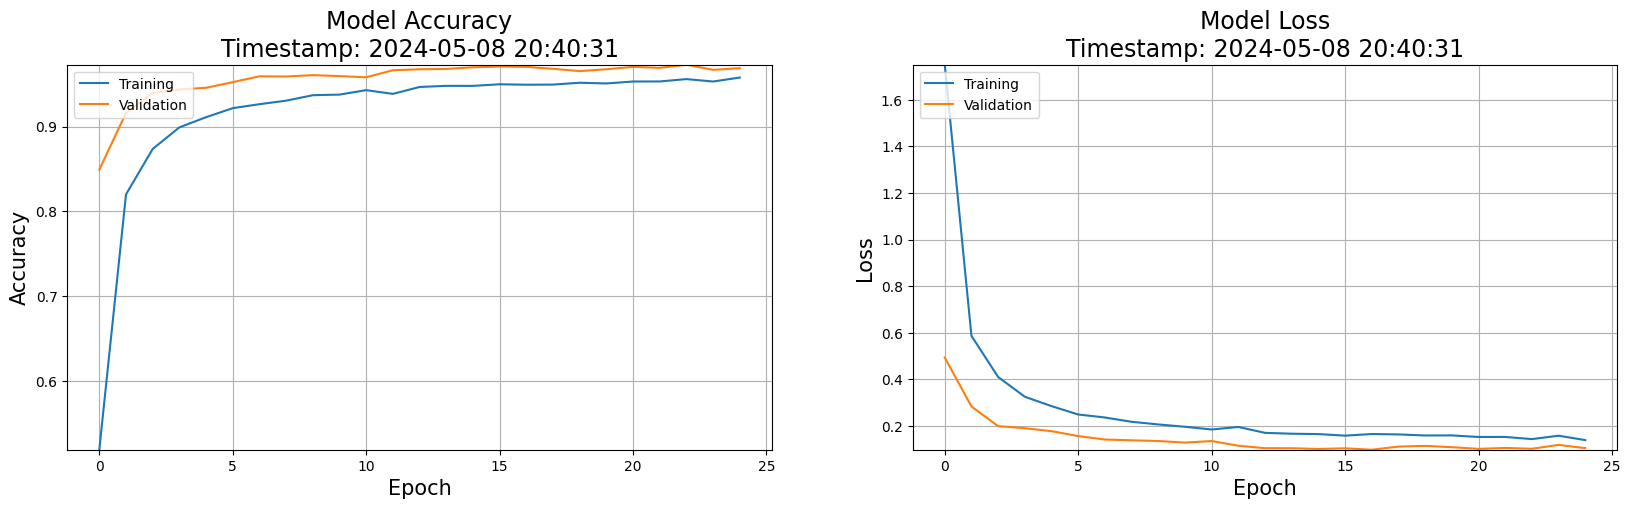

In [ ]:
plot_performance(history=history1)

In [ ]:
# testing accuracy on test dataset
from sklearn.metrics import accuracy_score

# Importing the test dataset
y_test = pd.read_csv('dataset/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('dataset/'+img)
        image = image.resize([30, 30])
        data.append(np.array(image))

X_test=np.array(data)

In [14]:
# X_test = X_test.astype(np.float32)
# with tf.device('/GPU:0'):
#     pred = np.argmax(model.predict(X_test), axis=-1)


# #Accuracy with the test data
# from sklearn.metrics import accuracy_score
# print(accuracy_score(labels, pred))

# Normalize the test data
X_test = X_test.astype(np.float32)

# Predict the class indices
with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

# Convert `y_test` back to class indices
true_labels = np.argmax(y_test, axis=-1)

# Accuracy with the test data
accuracy = accuracy_score(true_labels, pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.76%


In [ ]:
# Saving the Model 
model.save('traffic_classifier_with_imageprocessing.h5')

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocessing(img, use_clahe=False, augment=False, use_filters=False, show_intermediate=False):
    """
    Preprocess the image with options for CLAHE, augmentation, and filters.
    
    Parameters:
        img (numpy.ndarray): The input image in BGR format.
        use_clahe (bool): Whether to apply CLAHE.
        augment (bool): Whether to apply random augmentations.
        use_filters (bool): Whether to apply filtering techniques.
        show_intermediate (bool): Whether to display intermediate results.
    
    Returns:
        numpy.ndarray: The preprocessed image.
    """
    def show_image(title, image):
        plt.figure()
        plt.title(title)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()

    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show_intermediate:
        show_image('Grayscale', img_gray)

    # Apply CLAHE if specified
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_gray = clahe.apply(img_gray)
        if show_intermediate:
            show_image('After CLAHE', img_gray)

    # Apply filters if specified
    if use_filters:
        # Gaussian Blur
        img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
        if show_intermediate:
            show_image('After Gaussian Blur', img_blur)

        # Sobel Edge Detection
        sobelx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(img_blur, cv2.CV_64F, 0, 1, ksize=5)
        img_sobel = cv2.magnitude(sobelx, sobely)
        if show_intermediate:
            show_image('After Sobel Edge Detection', img_sobel)

        # Sharpening
        kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]])
        img_sharpen = cv2.filter2D(img_sobel, -1, kernel)
        if show_intermediate:
            show_image('After Sharpening', img_sharpen)

        # Assign the final processed image after filtering
        img_gray = img_sharpen

    # Normalize the image to the range [0, 1]
    img_normalized = img_gray / 255.0
    if show_intermediate:
        show_image('Final Output After Normalization', img_normalized)

    # Apply augmentation if specified
    if augment:
        if np.random.rand() > 0.5:
            # Rotate the image
            angle = np.random.randint(-15, 15)
            M = cv2.getRotationMatrix2D((img_normalized.shape[1]//2, img_normalized.shape[0]//2), angle, 1.0)
            img_normalized = cv2.warpAffine(img_normalized, M, (img_normalized.shape[1], img_normalized.shape[0]))
        
        if np.random.rand() > 0.5:
            # Scale the image
            scale = np.random.uniform(0.9, 1.1)
            height, width = img_normalized.shape[:2]
            new_height, new_width = int(height * scale), int(width * scale)
            img_scaled = cv2.resize(img_normalized, (new_width, new_height))
            img_normalized = cv2.resize(img_scaled, (width, height))  # Resize back to original size

    return img_normalized

# Example Image (replace this with an actual image)
img_path = 'dataset/Train/0/00000_00000_00000.png'  # Replace with a path to your test image
img = cv2.imread(img_path)

# Preprocess the image and print intermediate outputs
output_img = preprocessing(img, use_clahe=True, augment=False, use_filters=True, show_intermediate=True)
